In [ ]:

!pip install ultralytics
!pip install supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 6.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
!pip install -Uqq fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.9 MB/s eta 0:00:00


In [ ]:

from ultralytics import YOLO
import supervision as sv
from PIL import Image
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML
from base64 import b64encode

from fastbook import *
from fastai.vision.widgets import *

### Load pre-trained YOLOv8 model

In [ ]:

MODEL = "yolov8x.pt"
model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 279MB/s]


YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [ ]:

def play_video(video_path, width=200):
  mp4 = open(video_path,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML(f"""

  """)

### Inferencia

In [ ]:
import torchvision.models as models
import torch.nn as nn

# Load EfficientNet model for classification
eff_model = models.efficientnet_b0(pretrained=True)
num_ftrs = eff_model.classifier[1].in_features
eff_model.classifier[1] = nn.Linear(num_ftrs, 2)  # Your model has 2 classes
model_state = torch.load('/content/drive/MyDrive/IA3/behavior2/dataset/best/bestefficientnetb0.pt', map_location=torch.device('cuda'))
eff_model.load_state_dict(model_state)
eff_model.eval()
eff_model.to(torch.device('cuda'))

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
import torchvision.transforms as transforms

In [ ]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # EfficientNet-B0 expects 224x224 input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# class_ids of interest - car, motorcycle, bus and truck
selected_classes = [2, 3, 5, 7]

def infer(video_path):
    # Informacion del video
    video_info = sv.VideoInfo.from_video_path(video_path=video_path)
    height, width = video_info.height, video_info.width
    # Frames del video
    frames_generator = sv.get_video_frames_generator(source_path=video_path)
    frames_list = [frame for frame in frames_generator]
    print('frames:',len(frames_list))
    # Seguimiento
    tracker = sv.ByteTrack()
    # Extraccion de imagenes de la trayectoria del video
    imgs = {}
    end_img = frames_list[-1]
    for i, frame in enumerate(frames_list):
        print('forma imagen:',frame.shape)
        result = model(frame)[0]
        detections = sv.Detections.from_ultralytics(result)
        detections = tracker.update_with_detections(detections)
        for xyxy, mask, confidence, class_id, tracker_id, data in detections:
            #print('mask:',mask)
            if class_id in selected_classes:
                list_id = list(imgs.keys())
                if tracker_id not in list_id:
                    imgs[tracker_id] = {'img1':np.zeros((height,width,3), np.uint8),
                                        'img2':end_img.copy(),
                                        'class':class_id}
                # Obtener xy a partir de xyxy
                xyxy = xyxy.reshape(1,4)
                xy = np.array(
                            [
                                (xyxy[:, 0] + xyxy[:, 2]) / 2,
                                (xyxy[:, 1] + xyxy[:, 3]) / 2,
                            ]
                        ).transpose()
                # Modifica img1 y img2
                imgs[tracker_id]['img1'] = cv2.polylines(
                            imgs[tracker_id]['img1'],
                            [xy.astype(np.int32)],
                            True,
                            color=(255,0,0),
                            thickness=10
                        )
                imgs[tracker_id]['img2'] = cv2.polylines(
                            imgs[tracker_id]['img2'],
                            [xy.astype(np.int32)],
                            True,
                            color=(255,0,0),
                            thickness=10
                        )
        # Use EfficientNet model for classification
        for k, v in imgs.items():
          img_tensor = preprocess(v['img1']).unsqueeze(0).to('cuda')
          with torch.no_grad():
              prediction = eff_model(img_tensor)
              predicted_class = prediction.argmax(dim=1).item()
              imgs[k]['predict'] = predicted_class




    return imgs

    print('id:',imgs.keys())
    return imgs


In [ ]:
# Llamar a la función de inferencia
video_path = '/content/drive/MyDrive/IA3/behavior2/dataset/videos conduccion erratica/Proyecto 1.mp4'
imgs = infer(video_path)
print('ids:', list(imgs.keys()))

frames: 75
forma imagen: (1080, 1920, 3)

0: 384x640 1 person, 2 cars, 1 potted plant, 110.2ms
Speed: 12.5ms preprocess, 110.2ms inference, 840.6ms postprocess per image at shape (1, 3, 384, 640)
forma imagen: (1080, 1920, 3)

0: 384x640 1 person, 2 cars, 1 motorcycle, 1 potted plant, 61.9ms
Speed: 2.6ms preprocess, 61.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
forma imagen: (1080, 1920, 3)

0: 384x640 1 person, 2 cars, 1 potted plant, 61.9ms
Speed: 2.8ms preprocess, 61.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
forma imagen: (1080, 1920, 3)

0: 384x640 1 person, 2 cars, 1 potted plant, 55.5ms
Speed: 4.0ms preprocess, 55.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
forma imagen: (1080, 1920, 3)

0: 384x640 1 person, 2 cars, 1 potted plant, 50.0ms
Speed: 3.1ms preprocess, 50.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
forma imagen: (1080, 1920, 3)

0: 384x640 1 person, 2 cars, 1 potted p

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
imgs.keys()

dict_keys([1, 3, 6])

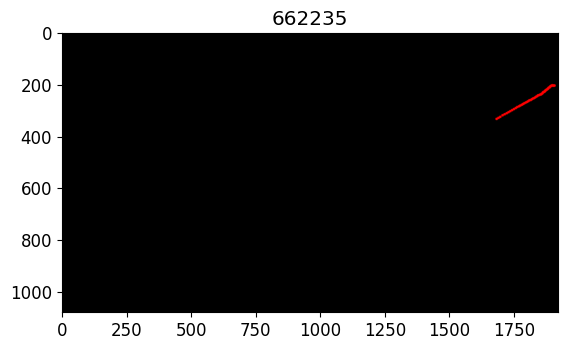

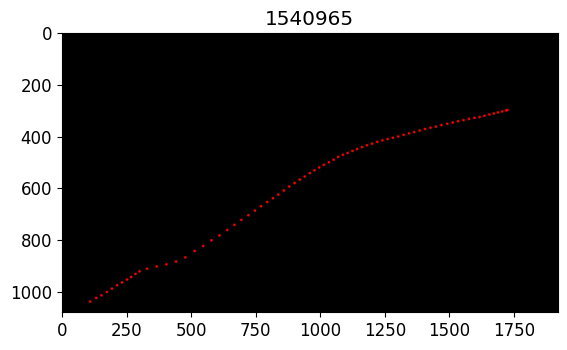

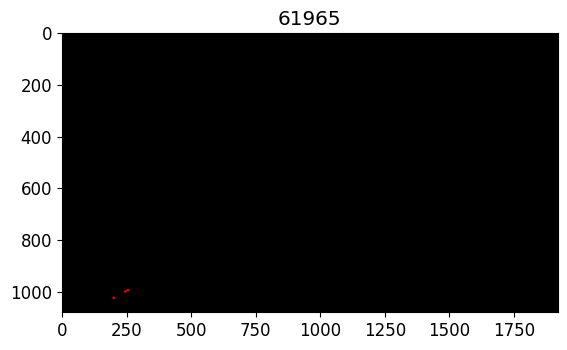

In [ ]:
for k, v in imgs.items():
    image = Image.fromarray(v['img1'])
    plt.imshow(image)
    plt.title(f"{v['img1'].sum()}")
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
def print_classification_results(imgs):
    for tracker_id, data in imgs.items():
        # Extract classification and other relevant data
        classification = data.get('predict', 'No prediction')
        class_label = 'incorrecto' if classification == 1 else 'correcto'

        # Print out the tracker ID and its classification
        print(f"Tracker ID: {tracker_id}, Classification: {class_label} ({classification})")

        # If you want to show the sum of the image to verify content
        image_sum = data['img1'].sum()
        print(f"Image Sum: {image_sum}")

        # Optionally, display the image using matplotlib (commented out by default)

        image = Image.fromarray(data['img1'])
        plt.imshow(image)
        plt.title(f"Tracker ID: {tracker_id}, Class: {class_label}")
        plt.show()

Tracker ID: 1, Classification: correcto (0)
Image Sum: 662235


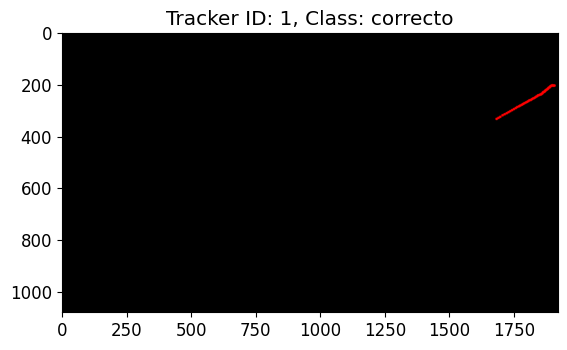

Tracker ID: 3, Classification: incorrecto (1)
Image Sum: 1540965


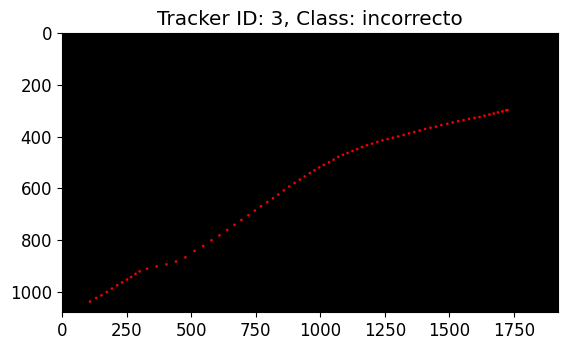

Tracker ID: 6, Classification: correcto (0)
Image Sum: 61965


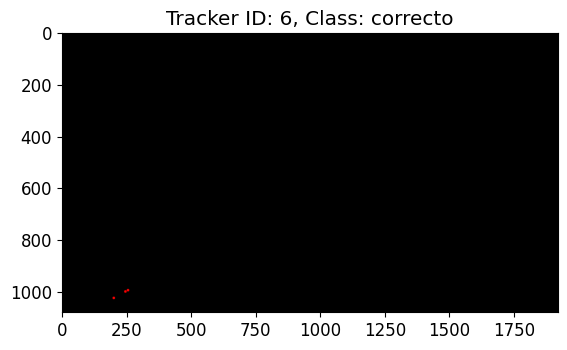

In [ ]:

# Print detailed classification results
print_classification_results(imgs)

In [ ]:
# Llamar a la función de inferencia
video_path2 = '/content/drive/MyDrive/IA3/behavior2/dataset/videos conduccion erratica/Proyecto 1.mp4'
imgs2 = infer(video_path2)
print('ids:', list(imgs2.keys()))

Demo gradio

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 12.5 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl s

In [ ]:
import gradio as gr

In [ ]:

def generar_resultados_demo(video_path):
    imgs = infer(video_path)
    list_result = []
    for k,v in imgs.items():
        if v['img1'].sum()>500000:
            list_result += [v['img2'], v['img1'], dict(zip(['correcto','incorrecto'], v['predict'][2].tolist()))]
    list_result = list_result[:3]
    print(list_result)
    # if len(list_result)<6:
    #     list_result += [i for i in range(6-len(list_result))]
    return list_result

In [ ]:
with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            video = gr.Video()
            btn = gr.Button("Run")
        with gr.Column():
            with gr.Row():
                c1i1 = gr.Image(scale=1)
                c1i2 = gr.Image(scale=1)
                l1 = gr.Label()
            with gr.Row():
                c2i1 = gr.Image(scale=1)
                c2i2 = gr.Image(scale=1)
                l2 = gr.Label()
    btn.click(generar_resultados_demo, inputs=video, outputs=[c1i1, c1i2, l1, c2i1, c2i2, l2])
    examples = gr.Examples(examples=['/content/drive/MyDrive/IA3/behavior2/dataset/videos conduccion erratica/Proyecto 10.mp4',
                                     '/content/drive/MyDrive/IA3/behavior2/dataset/videos conduccion normal/Proyecto 23n.mp4'], inputs=video)
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://87a296d1cce66dcc2f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
